## Part 1 ‐ Exploratory Data Analysis
logins.json file contains timestamps of user logins in (one) particular geographic location 
1. Aggregate these **login counts** based on **15 minute time intervals**
2. Visualize and describe the resulting time series of login counts
    - Goal: Characterize the patterns of the demand
3. Report/illustrate important features of the demand, such as daily cycles 
4. Report any data quality issues

In [47]:
# Import the relevant python libraries for the analysis
import pandas as pd
from pandas import DataFrame
import numpy as np

In [48]:
# Load json dataset
login_data = pd.read_json('logins.json')
login_data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


Observations: 
    1. All years are the same in dataset (1970)
    2. Months range from 1 (January) to 4 (April)
    3. Day stops on 4 (April) 13
    5. Some entries only vary by second of login

In [49]:
# Assess the dataframe
login_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [50]:
login_data.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


### Aggregate these login counts based on 15 minute time intervals
Step 1: Make timestamp column the login_data_df index

In [51]:
login_data.set_index('login_time', inplace=True)
login_data.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


Step 2: Add a numeric column to track counts (each entry counts as 1)

In [52]:
login_data['counts'] = 1
login_data.head()

,counts
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


Step 3: Group entries by 15 minute intervals

In [53]:
login_data_15T = login_data.resample(rule='15T').sum()
login_data_15T.head()

,counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Step 4: Convert timestamp index back to column

In [54]:
login_data_15T = login_data_15T.reset_index()
login_data_15T.head()

,login_time,counts
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


### Visualize and describe the resulting time series of login counts
Goal: Characterize the daily, weekly, and monthly patterns of the demand

In [12]:
# Import necessary modules
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns; sns.set(style="darkgrid")

Step 1: Monthly Pattern

In [88]:
# Make subdfs for each month - select month by range 
jan = login_data_15T[(login_data_15T.login_time > '1970-01') & (login_data_15T.login_time < '1970-02')]
print('Length of January Data is ', len(jan.login_time))
feb = login_data_15T[(login_data_15T.login_time > '1970-02') & (login_data_15T.login_time < '1970-03')]
print('Length of February Data is ', len(feb))
mar = login_data_15T[(login_data_15T.login_time > '1970-03') & (login_data_15T.login_time < '1970-04')]
print('Length of March Data is ', len(mar))
apr = login_data_15T[(login_data_15T.login_time > '1970-04') & (login_data_15T.login_time < '1970-05')]
print('Length of April Data is ', len(apr))

Length of January Data is  2896
Length of February Data is  2687
Length of March Data is  2975
Length of April Data is  1227


*Observation*: It appears that April data is a little under half as large as the proceeding 3 months of 1970. 

In [90]:
# Test April output
apr.login_time.tail(1)

9787   1970-04-13 18:45:00
Name: login_time, dtype: datetime64[ns]

*Observation*: April data stops on the 13th of the month, so total analysis is of ~3.5 months.

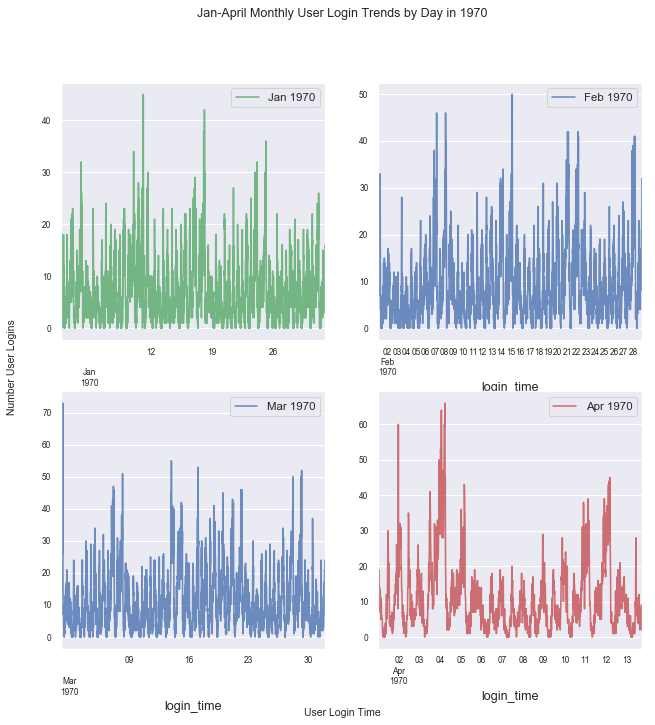

In [101]:
# Visualization of Monthly Data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10, 10), dpi=75)

# Set common labels
fig.suptitle('Jan-April Monthly User Login Trends by Day in 1970')

# Define Monthly subplots
jan.plot(ax=ax1, x='login_time', y='counts', color='g', alpha=.8, fontsize=8, label='Jan 1970')
feb.plot(ax=ax2, x='login_time', y='counts', color='b', alpha=.8, fontsize=8, label='Feb 1970')
mar.plot(ax=ax3, x='login_time', y='counts', color='b', alpha=.8, fontsize=8, label='Mar 1970')
apr.plot(ax=ax4, x='login_time', y='counts', color='r', alpha=.8, fontsize=8, label='Apr 1970')

# Set common labels
fig.text(0.5, 0.04, 'User Login Time', ha='center', va='center')
fig.text(0.06, 0.5, 'Number User Logins', ha='center', va='center', rotation='vertical')

# Set x tick frequency
#[ax.set_xticks(np.arange(0, 32, step=2)) for ax in [ax1, ax2, ax3, ax4]]

plt.show()

*Observations*: There appears to be a similar fluctuation of user logins within each month, which implies that there is most likely a measurable variation of user logins by day.

Step 2: Daily Pattern

In [109]:
# Counting based on weekdays, 0 = Monday, 6 = Sunday
login_data_15T['weekday'] = login_data_15T['login_time'].dt.dayofweek

# Create weekday subdf
weekday = login_data_15T.sort_values(by='counts', ascending=False)
weekday = weekday[['counts', 'weekday']]
weekday = weekday.groupby('weekday').sum().reset_index()

# Rename columns
weekday['day'] = ['Mon','Tues','Wed','Thurs','Fri','Sat','Sun']
weekday

,weekday,counts,day
0,0,8823,Mon
1,1,9268,Tues
2,2,10339,Wed
3,3,11960,Thurs
4,4,15208,Fri
5,5,19377,Sat
6,6,18167,Sun


Text(0.5, 1.0, 'Count of Logins by Weekday from Jan to mid-Apr 1970')

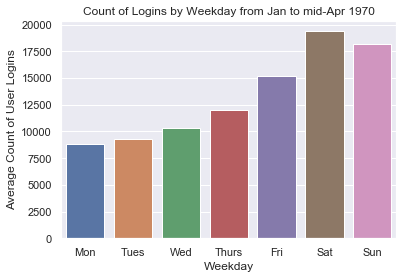

In [118]:
# Plot weekday counts 
sns.barplot(x='day', y='counts', data=weekday)
plt.ylabel('Average Count of User Logins')
plt.xlabel('Weekday')
plt.title('Count of Logins by Weekday from Jan to mid-Apr 1970')

*Observations*: There appears to be an increase in user logins as the week progresses from Monday, with a spike on Saturday, slight decrease Sunday, and circles back to a large decrease in user logins on Monday.

Step 3: Hourly Pattern

In [122]:
# Splitting into hours
login_data_15T['hour'] = login_data_15T['login_time'].dt.hour
hours = login_data_15T
hours = hours[['counts', 'hour']]
hours = hours.groupby('hour').sum().reset_index()
#hours

Text(0.5, 1.0, 'Count of Logins by Hour in Jan to mid-Apr 1970')

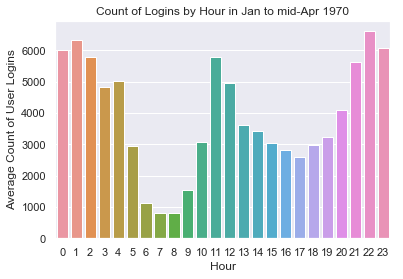

In [123]:
# Plot hour counts 
sns.barplot(x='hour', y='counts', data=hours)
plt.ylabel('Average Count of User Logins')
plt.xlabel('Hour')
plt.title('Count of Logins by Hour in Jan to mid-Apr 1970')

*Observations:* User logins appear to be greatest in the early and later hours of the day, with peaks in the early afternoon around lunchtime.

**IN SUMMARY**:
    User logins to Ultimate riseshare increase as the week progresses from Monday, with a spike on Saturday, slight decrease Sunday, and circles back to a large decrease in user logins on Monday. In addition, logins appear to be greatest in the early and later hours of the day, with peaks in the early afternoon around lunchtime. This is based off of data from months January through March, plus half a month of data from April, in 1970.